# Lab 6 - Autoencoders (graded lab)

In this lab, you will get hands-on experience with dimension reduction techniques: Priciple Component Analysis and Autoencoders. The next lab will include a deep generative modelling technique: Variational Autoenceoders.  

The goal of dimension reduction is to find a suitable transformation which converts a high dimensional space into a smaller feature space, such that the important information is not lost.

**Guidelines for the graded lab:**
* The lab should be sent to marine.le-morvan@inria.fr before next Tuesday midnight.
* Labs should be sent in html format (with all cells exectued).
* Name your lab as lab6_yourname.html
* Quality of the code and figures will be taken into account.
* If you think something is weird in your results but you can't figure out why, you can add a comment on this.
* This is a personal assignment. Therefore, there should not be inadequate similarities between your lab and someone else's lab.


## Table of contents


[1. PCA for dimension reduction](#pca)<br>
[1.1 Some theory](#pca_some_theory)<br>
[1.2 Applying SVD](#pca_applying_svd)<br>
[1.3 Choosing the number of components to keep](#pca_chosing_nb_components)<br>
[1.4 Reconstructing images](#pca_reconstructing_images)<br>

[2. Autoencoders](#autoencoders)<br>
[2.1 Linear Autoencoder](#autoencoders_linear)<br>
[2.2 Nonlinear Autoencoder](#autoencoders_nonlinear)<br>
[2.3 Comparing the reconstructed images](#autoencoders_comparing)<br>

We will use the MNIST digits dataset throughout this exercise.  The MNIST dataset provides 60000 28x28=784 pixel grayscale training images of hand-written digits 0-9.  The images are labeled with integer values 0-9. In this exercise, we are not interested in classifying images of digits.  Instead, we are interested in transforming the 784-dimentional features into a smaller set of transformed coordinates. Throughout this lab, we will use Python and PyTorch.

**1) Load the MNIST dataset using the `torchvision`package. Scale the data into [0, 1]. Verify the structure of the training/test set and plot an image.**  

In [ ]:
import torch
import torchvision
from sklearn.metrics import mean_squared_error
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())  # scaling data into [0,1] by using ToTensor
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())  # scaling data into [0,1] by using ToTensor

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
print("Verifying the structure of training set")
print("Number of elements in train set: ",len(train_data))              
print("Size of image in train set: ",train_data[0][0].size())     
print("Type of label in train set: ",type(train_data[0][1]))            

Verifying the structure of training set
Number of elements in train set:  60000
Size of image in train set:  torch.Size([1, 28, 28])
Type of label in train set:  <class 'int'>


In [ ]:
print("Verifying the structure of test set")
print("Number of elements in test set: ",len(test_data))              
print("Size of image in test set: ",test_data[0][0].size())      
print("Type of label in test set: ",type(test_data[0][1]))          

Verifying the structure of test set
Number of elements in test set:  10000
Size of image in test set:  torch.Size([1, 28, 28])
Type of label in test set:  <class 'int'>


Plotting an image from training data
The label is:  5


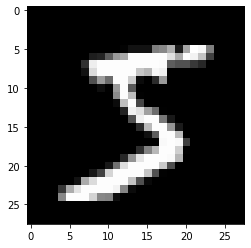

In [ ]:
print('Plotting an image from training data')
img, label = train_data[0]
print('The label is: ',label)
plt.imshow(img.squeeze(), cmap="gray")

Plotting an image from test data
The label is:  7


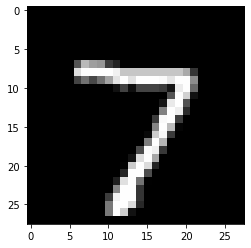

In [ ]:
print('Plotting an image from test data')
img, label = test_data[0]
print('The label is: ',label)
plt.imshow(img.squeeze(), cmap="gray")

**2) Reshape the data into N x D tensors where N is the number of samples.**

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=len(train_data), shuffle=True)
test_dataloader = DataLoader(test_data, batch_size = len(test_data), shuffle=True)

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
test_features, test_labels = next(iter(test_dataloader))

In [ ]:
print("Reshaping data into N * 784 ...")
train_features = train_features.view(60000,-1)
test_features = test_features.view(10000,-1)

print('Checking size of obtained tensors: ')
print("Shape of new train tensor: ",train_features.shape)
print("Shape of new test tensor: ",test_features.shape)

Reshaping data into N * 784 ...
Checking size of obtained tensors: 
Shape of new train tensor:  torch.Size([60000, 784])
Shape of new test tensor:  torch.Size([10000, 784])


## 1. Compressing images via PCA
<a id='pca'></a>

### 1.1 Some theory
<a id='pca_some_theory'></a>

### Principal Component Analysis

The goal of PCA is to create new variables (principal components) that are linear combinations of original variables such that the set of observations, once projected onto this new set of variables, has the largest dispersion/variance/inertia. 

Let us consider a dataset $X\in R^{n\times p}$, where $n$ is the number of observations and $p$ the number of variables.  PCA transforms $X$ into a new coordinate system (new variable set), such that the greatest variance in the data is captured in the first coordinate, and then the second, and so on.  More specifically, the transformed coordinates $T \in R^{n\times p}$ are written as linear combinations of the original dataset,

$$ T = X W, $$

where $W \in R^{p\times p}$ is the transformation matrix.

The expression of $W$ can be found as follows. Let $\bar{x}$ be the mean vector for the samples in $X$. Let $u$ be a unit norm vector. The variance according to direction $u$ is given by:
\begin{align}
    \frac{1}{n} \sum_{i=1}^n (x_i^\top u - \bar{x}^\top u)^2 &= \frac{1}{n} \sum_{i=1}^n \left[(x_i - \bar{x})^\top u\right]^\top (x_i - \bar{x})^\top u\\
    &= u^\top \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x}) (x_i - \bar{x})^\top u\\
    &= u^\top \Sigma u
\end{align}
where $\Sigma$ is the estimated variance covariance matrix of $X$.

Thus, the direction of maximum variance can be obtained by solving the following maximisation problem:
$$\underset{\lVert u \rVert = 1} \max u^\top \Sigma u$$

You can check that the solution to this problem is the largest eigenvector of $\Sigma$, and that the corresponding maximum is its largest eigenvalue.

The next principal components can be found by solving the same maximisation problem under the additional constraints that they should be orthogonal to previously found components. It can be shown by induction that the solutions to these problems are in fact the 2nd, 3rd, etc... eigenvectors of $\Sigma$. 

Practically, the columns of $W$ are typically computed as the eigenvectors of the estimated covariance matrix ordered by their corresponding eigenvalues in descending order. Or, since the eigenvectors of the estimated covariance matrix are equal to the right singular vectors of the centered data, the columns of $W$ can be computed as the right singular vectors of the **centered data**.


### Dimensionality Reduction

We can reduce the dimensionality of our data by truncating the transformed variables to include only a subset of those variables with the highest variance.  For example, if we keep the first $L <= p$ variables, the reduced transformation reads

$$ T_L = X W_L, $$

where $W_L \in R^{p\times L}$ is the eigenvector matrix as before, but taking only the first $L$ columns.  This technique has been widely used to reduce the dimension of high-dimensionional datasets by accounting for the directions of largest variance in the data, while neglecting the other directions.  In addition, this can also be used to remove noise from a dataset, in which it is assumed that the noise is independent of all original variables. Finally, using PCA to find the 2 highest varying parameters can also allow us to visualize a high-dimensional dataset.  Let's do this now on the MNIST images.



### 1.2 Applying SVD
<a id='pca_applying_svd'></a>

**3) Apply a SVD on the flattened MNIST images from the training set to recover the principal components. Project the data set onto the first two components. Plot this new data set of dimension two, using the labels of images as colors. Comment.**

You can use `numpy.linalg.svd`. Plot only the first 1000 samples from the train set.
Use `plt.cm.tab10` as colormap for yout plot.

In [ ]:
u, s, vh = np.linalg.svd(train_features, full_matrices = False) 

In [ ]:
new_coordinates_0 = np.dot(train_features[:1000], vh[0])  # projecting dataset on first component
new_coordinates_1 = np.dot(train_features[:1000], vh[1])  # projecting dataset on second component

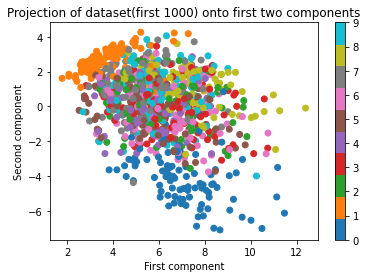

In [ ]:
plt.title('Projection of dataset(first 1000) onto first two components')
plt.xlabel('First component')
plt.ylabel('Second component')

plt.scatter(new_coordinates_0, new_coordinates_1, c = train_labels[:1000], cmap ='tab10')
plt.colorbar()
plt.show()

Comments on the plot: 

We can see by looking at the plotting above, that by projecting the dataset on first two components(thus using only the first 2 vectors) some grouping can be observed. For instance, the digits 0,1 are well grouped. The grouping of other labels is not ideal.  

### 1.3 Choosing the number of components to keep
<a id='pca_chosing_nb_components'></a>

It is not always clear how many principle components are necessary to accurately represent a high-dimensional space.  The most widely used method consists in plotting the variance associated to all previous components and to find the inflexion point in the curve, hence the name 'elbow rule'. 

**4) Using the elbow rule, give a number of components to keep for the MNIST data set.**

In [ ]:
indices = [i for i in range(0,784)]

In [ ]:
variances = np.zeros(784)
sum = 0
for i in range(0,784):
    variances[i] = s[i]*s[i] + sum
    sum = sum + s[i]*s[i]

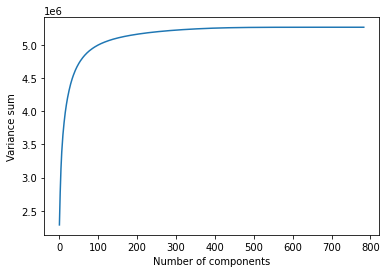

In [ ]:
plt.xlabel('Number of components')
plt.ylabel('Variance sum')
plt.plot(indices,variances)

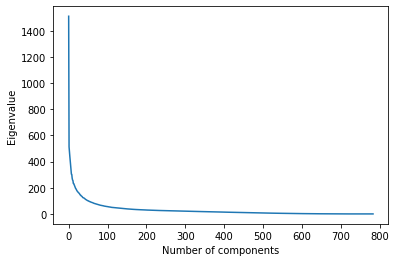

In [ ]:
plt.xlabel('Number of components')
plt.ylabel('Eigenvalue')
plt.plot(indices,s)

Comments: 

By looking at both of the above graphs, we can see that according to the elbow rule the inflexion point is around the number of components = 100. It means that 100 components should be kept for MNIST dataset.

### 1.4 Reconstructing Images
<a id='pca_reconstructing_images'></a>

Now that we have an idea of how many principle components are necessary, let's use them to encode the images in a smaller set of features, which we can then decode to reconstruct the images from the lower-dimensional space.  Recall that based on the PCA transformation, we can compute the reconstructed images with

$$ \hat{X} = (X W_L) W_L^T, $$

where $W_L \in R^{p\times L}$.

**5) Create a 6x5 grid of images such that: $(i)$ the first row contains the first 5 images of the dataset, $(ii)$ the next 5 rows contain the corresponding reconstructed images using the first 2, 15, 30, 100 and 200 principle components.**

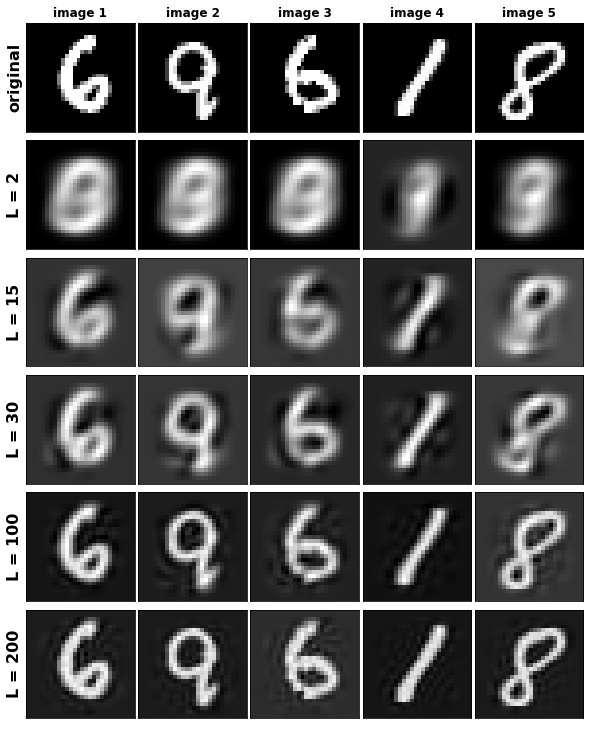

In [ ]:
xlabels = ['image 1','image 2','image 3','image 4','image 5']
ylabels = ['original', 'L = 2', 'L = 15', 'L = 30', 'L = 100', 'L = 200']
number_of_components = [0,2,15,30,100,200]
fig, axs = plt.subplots(6,5, figsize=(8,10))

for i in range(6):
    axs[i,0].set_ylabel(ylabels[i], fontsize=16,fontweight='bold')
    if i != 0:
        k = number_of_components[i]
        outp = np.matmul(np.matmul(train_features, vh[:k,:].T), vh[:k,:])
    for j in range(5):
        if i==0:
            axs[i,j].set_title(xlabels[j], fontweight='bold')
            axs[i,j].imshow(train_features[j].reshape(28,28), cmap="gray")
        else:
            axs[i,j].imshow(outp[j].reshape(28,28), cmap="gray")
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
fig.tight_layout(pad=0)

**6) Compute the MSE on the test set between the original and reconstruced images for each number of principal components.**  
Present the results as a curve giving teh recinstruction MSE as a function of teh number of components.

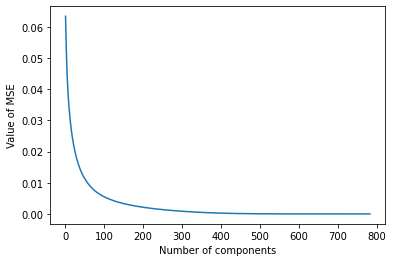

In [ ]:
u_test, s_test, vh_test = np.linalg.svd(test_features, full_matrices = False) 

errors = []
components_values = [x for x in range(1,784)]
for k in range(1,784):
    reconstructed_test = np.matmul(np.matmul(test_features, vh_test[:k,:].T), vh_test[:k,:])
    errors.append(mean_squared_error(test_features, reconstructed_test))
plt.xlabel("Number of components")
plt.ylabel("Value of MSE")
plt.plot(components_values,errors)

**Remark.** Note that once we have computed the transformation matrix $W$, we essentially have a compression scheme to convert our images into a compressed format.  From this perspective, using the first 5, 10, 30, and 100 principle components is equivalent to compressing the data at a rate of 156:1, 78:1, 26:1, and 8:1, respectively.  By contrast, JPEG image compression can obtain compression ratios of 23:1 with reasonable image quality, surpassing the quality of reconstructions with PCA.  For that reason, PCA is not really used for image compression, but it has been used in a number of other fields, particularly in physics and engineering.

## 2. Autoencoders
<a id='autoencoders'></a>

In this part, we will devise a compression strategy using another method, autoencoders.  Autoencoders are neural networks which are trained to output their input in such a way that they learn a reduced dimensional space of the input distribution.  Usually, they are composed of two distinct parts. The first one encodes the input space (encoder) and the second one decodes the encoded space back to the original feature space (decoder).  There are different types of autoencoders, among which:
1. __Undercomplete autoencoders__ work by constructing a network whose intermerdiate layer (the layer between the encoder and decoder) has fewer nodes than the input and output layers.  After training, the smaller hidden layer will represent an encoding of the input onto a lower dimensional space.
2. __Regularized autoencoders__ use various regularization terms in the loss function during training. For example, sparse autoencoders add a sparsity regularization term in the loss to force as many nodes in the hidden layers to be zero.
3. __Variational autoencoders__ are very different.  In this case, the encoder learns parameters that model the distribution of the latent variables given the input variables. The decoder learns parameters of the input given the latent variables. Based on a random sample of the latent variable, the decoder can be used to generate new samples.  Some variational autoencoders have been used for image generation. 

In this exercise, we will construct two undercomplete autoencoders and train them on the MNIST data.

### 2.1 Linear autoencoder
<a id='autoencoders_linear'></a>

Consider an autoencoder with linear encoder and decoder, and a mean-squared-error loss function. 

**7) How is such a linear autoencoder related to PCA? What would be the latent subpace learned by a linear autoencoder?**

In [ ]:
# Linear autoencoder is related to PCA as in Linear autoencoder we also reduce the number of features (from Input 
# layer to hidden layer the number of nodes decreases). 
# The latent subspace learned by a linear autoencoder is the hidden layer (between encoder and decoder) with reduced number of features.

Let's now implement a simple linear autoencoder.

**8) Implement a linear autoencoder in PyTorch.**  
For now, use a 2-dimensional latent space for visualization purposes.

In [ ]:
class LinearAutoencoder(torch.nn.Module):
    def __init__(self, latent_space_size):
        super().__init__()
        self.encoder = torch.nn.Linear(784, latent_space_size)
        self.decoder = torch.nn.Linear(latent_space_size, 784)

    def forward(self, X):
        return self.decoder(self.encoder(X))

    def encode(self, X):
        return self.encoder(X)

**9) Train the linear autoencoder previsously implemented. Compare the MSE obtained on the train set compared to that obtained with PCA. Comment.**

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size = 32, shuffle=True)

In [ ]:
a = torch.tensor([1, 2, 3])
>>> b = torch.tensor([4, 5, 6])
>>> print(torch.column_stack((a, b)).shape)


torch.Size([3, 2])


In [ ]:
model = LinearAutoencoder(latent_space_size = 2)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

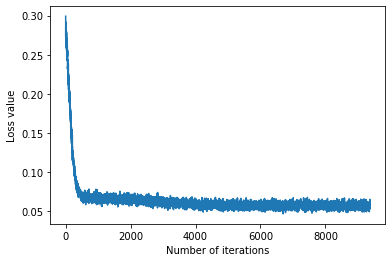

In [ ]:
epochs = 5
outputs = []
losses = []
loss_value = 0
for epoch in range(0,epochs):
    for (images, labels) in train_dataloader:
        images = images.reshape(-1,784)
        output_images = model(images)
        loss = loss_fn(output_images,images)
        print(loss)
        losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
plt.xlabel('Number of iterations')
plt.ylabel('Loss value')
plt.plot(losses)


In [ ]:
print("Value of MSE loss for PCA with 2 components: ",errors[1])
print("Value of MSE loss after 5 epochs of training Linear Autoencodes is ",losses[-1])

Value of MSE loss for PCA with 2 components:  0.05763251
Value of MSE loss after 5 epochs of training Linear Autoencodes is  tensor(0.0564, grad_fn=<MseLossBackward0>)


Comments :

As can be seen from previous cell, the value of MSE loss for PCA with number of components = 2 is very similar to MSE loss after 5 epochs of training Linear Autoencodes. Since the MSE loss has become stable by theend of the iterations after 5 epochs, we can infer that the loss value will not decrease considerably - so we can say that the performance of PCA and Linear Autoencoder is identical.

**10) Plot the two latent variables in a scatter plot as we did for PCA (for the same choice of points). How does the scatter plot compare to the one you made with PCA?**

In [ ]:
new_coordinates_LinearAE = model(train_features[:1000])

In [ ]:
new_coordinates_LinearAE = new_coordinates_LinearAE.detach().numpy()

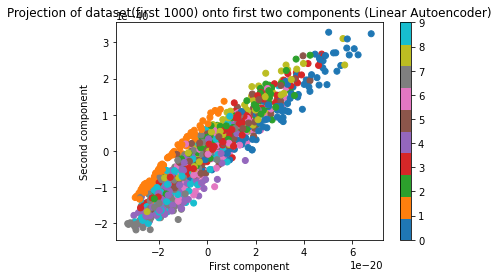

In [ ]:
plt.title('Projection of dataset(first 1000) onto first two components (Linear Autoencoder)')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.scatter(new_coordinates_LinearAE[:,0], new_coordinates_LinearAE[:,1], c = train_labels[:1000], cmap ='tab10')
plt.colorbar()
plt.show()

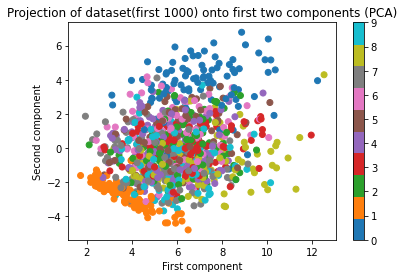

In [ ]:
plt.title('Projection of dataset(first 1000) onto first two components (PCA)')
plt.xlabel('First component')
plt.ylabel('Second component')

plt.scatter(new_coordinates_0, new_coordinates_1, c = train_labels[:1000], cmap ='tab10')
plt.colorbar()
plt.show()

Comments: 

by comparing the two scatter plots, it is possible to see that with Linear Autoencoder we were also able to achieve grouping of some labels. Again, we see that the digits 0,1 are well grouped using Linear Autoencoder(same for PCA). The grouping of other labels is not ideal.

### 2.2 Nonlinear Autoencoder
<a id='autoencoders_nonlinear'></a>

We are now going to turn to non-linear autoencoders. By allowing nonlinear transformations, we should be able to increase the expressiveness of our latent space. 


**11) Create a nonlinear autoencoder of your choice, but still with a latent space of size 2. Train it.**

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size = 32, shuffle=True)

In [ ]:
class NonLinearAutoencoder(torch.nn.Module):
    def __init__(self, latent_space_size):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, latent_space_size)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_space_size, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 784),
            torch.nn.Sigmoid()
        )

    def forward(self, X):
        return self.decoder(self.encoder(X))

    def encode(self, X):
        return self.encoder(X)

In [ ]:
model2 = NonLinearAutoencoder(latent_space_size = 2)
optimizer2 = torch.optim.Adam(model2.parameters())
loss_fn2 = torch.nn.MSELoss()

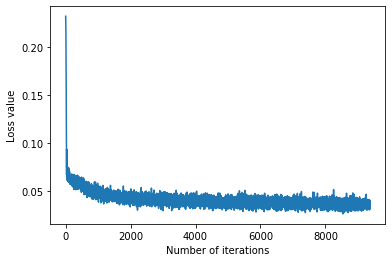

In [ ]:
epochs = 5
losses2 = []
for epoch in range(epochs):
    for (images, labels) in train_dataloader:
        images = images.reshape(-1,784)
        output_images = model2(images)
        loss = loss_fn2(output_images,images)
        losses2.append(loss)
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()


plt.xlabel('Number of iterations')
plt.ylabel('Loss value')
plt.plot(losses2)

**12) Plot the two latent variables in a scatter plot as we did for PCA (for the same choice of points). What can you say about the grouping of points using the nonlinear model?**

In [ ]:
new_coordinates_NonLinearAE = model2(train_features[:1000])
new_coordinates_NonLinearAE = new_coordinates_NonLinearAE.detach().numpy()

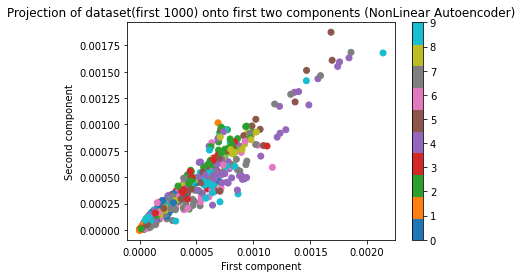

In [ ]:
plt.title('Projection of dataset(first 1000) onto first two components (NonLinear Autoencoder)')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.scatter(new_coordinates_NonLinearAE[:,0], new_coordinates_NonLinearAE[:,1], c = train_labels[:1000], cmap ='tab10')
plt.colorbar()
plt.show()

Comments: 
The grouping of points using non-linear method doesn't seem to be grouping properly any of the labels. (Whereas for PCA and Linear Autoencoders the grouping was better)

### 2.3 Comparing the reconstructed images
<a id='autoencoders_comparing'></a>


Finally, let's use our autoencoders to produce reconstructed images from the MNIST data as we did with PCA.

**13) Use the linear and non-linear AEs to produce reconstructed images. Generate a 3x5 grid of images such that $(i)$ the first row  contains the first 5 images of MNIST data set, $(ii)$ the second row contains their reconstruction using the linear AE, $(iii)$ the third row contains the reconstruction using the nonlinear AE. Comment.**

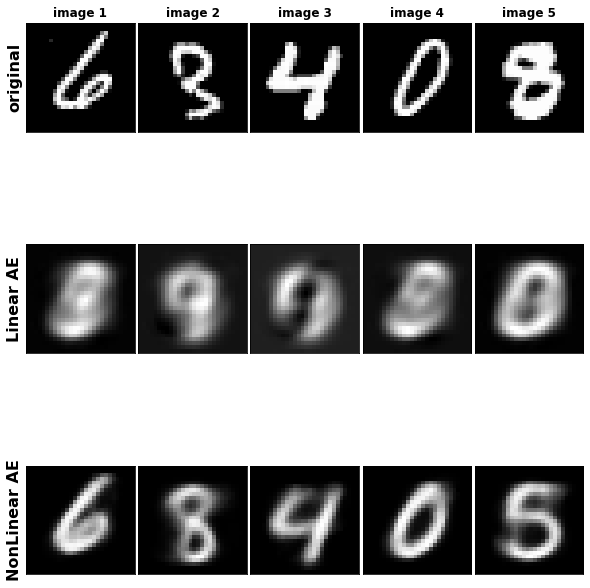

In [ ]:
xlabels = ['image 1','image 2','image 3','image 4','image 5']
ylabels = ['original', 'Linear AE', 'NonLinear AE']
fig, axs = plt.subplots(3,5, figsize=(8,10))

batch = (next(iter(train_dataloader)))
batch_data = batch[0].reshape(32, -1)

for i in range(3):
    axs[i,0].set_ylabel(ylabels[i], fontsize=16,fontweight='bold')
    if i == 1:
        images = model(batch_data)
        images = images.reshape(-1,28,28)
    if i == 2:
        images = model2(batch_data)
        images = images.reshape(-1,28,28)
    for j in range(5):
        if i==0:
            axs[i,j].set_title(xlabels[j], fontweight='bold')
            axs[i,j].imshow(batch_data[j].reshape(28,28), cmap="gray")
        else:
            axs[i,j].imshow(images[j].detach().numpy(), cmap="gray")
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
fig.tight_layout(pad=0)

Comments:    
We can observe by the above reconstructed images that the results obtained with Linear Autoencoder(with latent space of size 2) are very blurry and all similar to each other. It is impossible to distinguish a digit from those images.

However, with Non Linear Autoencoder with same latent space we observe more clear images, from which we can better see what digit is represented. The reconstructed images are more or less similar to the original ones. This is an expected behaviour, since with Non Linear Autoencoder we have introduced depth to both encoder and decoder, as well as included non-linearities. This leads to better reconstructed images, than with Linear Autoencoders.

**14) Retrain the linear and non-linear AEs with `code_size`=15, and plot the reconstructed images as above.**

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size = 32, shuffle=True)

In [ ]:
model_LIN_15 = LinearAutoencoder(latent_space_size = 15)
optimizer_LIN_15 = torch.optim.Adam(model_LIN_15.parameters())
loss_fn_LIN_15 = torch.nn.MSELoss()

In [ ]:
epochs = 5
outputs = []
losses = []
loss_value = 0
for epoch in range(0,epochs):
    for (images, labels) in train_dataloader:
        images = images.reshape(-1,784)
        output_images = model_LIN_15(images)
        loss = loss_fn_LIN_15(output_images,images)
        losses.append(loss)
        optimizer_LIN_15.zero_grad()
        loss.backward()
        optimizer_LIN_15.step()

In [ ]:
model_NONLIN_15 = NonLinearAutoencoder(latent_space_size = 15)
optimizer_NONLIN_15 = torch.optim.Adam(model_NONLIN_15.parameters())
loss_fn_NONLIN_15 = torch.nn.MSELoss()

In [ ]:
epochs = 5
losses2 = []
for epoch in range(epochs):
    for (images, labels) in train_dataloader:
        images = images.reshape(-1,784)
        output_images = model_NONLIN_15(images)
        loss = loss_fn_NONLIN_15(output_images,images)
        losses2.append(loss)
        optimizer_NONLIN_15.zero_grad()
        loss.backward()
        optimizer_NONLIN_15.step()

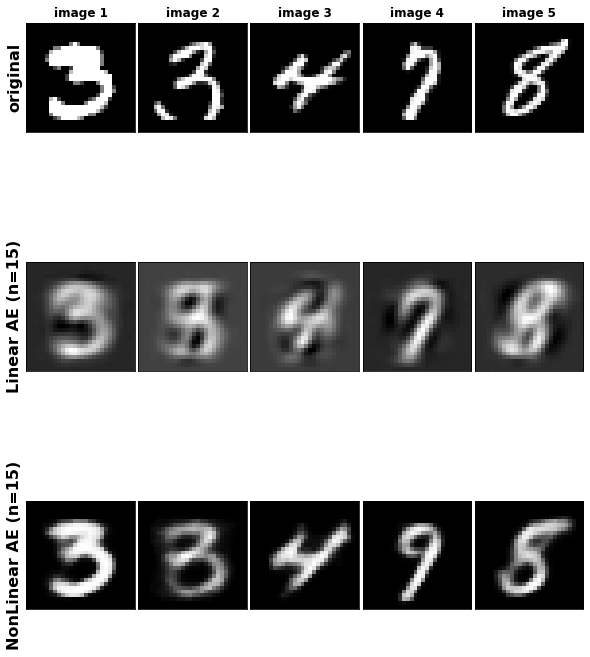

In [ ]:
xlabels = ['image 1','image 2','image 3','image 4','image 5']
ylabels = ['original', 'Linear AE (n=15)', 'NonLinear AE (n=15)']
fig, axs = plt.subplots(3,5, figsize=(8,10))

batch = (next(iter(train_dataloader)))
batch_data = batch[0].reshape(32, -1)

for i in range(3):
    axs[i,0].set_ylabel(ylabels[i], fontsize=16,fontweight='bold')
    if i == 1:
        images = model_LIN_15(batch_data)
        images = images.reshape(-1,28,28)
    if i == 2:
        images = model_NONLIN_15(batch_data)
        images = images.reshape(-1,28,28)
    for j in range(5):
        if i==0:
            axs[i,j].set_title(xlabels[j], fontweight='bold')
            axs[i,j].imshow(batch_data[j].reshape(28,28), cmap="gray")
        else:
            axs[i,j].imshow(images[j].detach().numpy(), cmap="gray")
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
fig.tight_layout(pad=0)

Comments:     
By increasing the size of latent space we can see improvements in quality of reconstructed images both of Linear and NonLinear Autoencoders. 

In [ ]:
%%shell
jupyter nbconvert --to html /content/lab6_Irada_Bunyatova.ipynb

[NbConvertApp] Converting notebook /content/lab6_Irada_Bunyatova.ipynb to html
[NbConvertApp] Writing 843897 bytes to /content/lab6_Irada_Bunyatova.html
